In [78]:
# Import al necessary libraries and packages needed for the project
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
import pytesseract
from pytesseract import Output
from prettytable import PrettyTable

In [79]:
# PreProcess the image

# Resize Image
def resizeImage(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# Tampilkan image grayscale
def displayGrayImage(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Aproksimasi kontur dengan bentuk poligon primitive
def approxContour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

# Mencari 4 sudut pada gambar
def getContour(contours):
    # Looping semua kontur
    for c in contours:
        approx = approxContour(c)
        # Jika kontur memiliki 4 sudut, bisa disimpulkan bahwa kontur tersebut adalah kontur yang dicari (kontur receipt)
        if len(approx) == 4:
            return approx

# Ubah 4 sudutmenjadi garis yang terhubung membentuk persegi
def contourToRect(contour):
    points = contour.reshape(4, 2)
    rectangle = np.zeros((4, 2), dtype = np.float32)
    s = points.sum(axis = 1)
    rectangle[0] = points[np.argmin(s)]
    rectangle[2] = points[np.argmax(s)]
    # Hitung selisih antara titik sudut
    # sudut kanan atas memiliki selisih yang lebih kecil
    # sudut kiri bawah memiliki selisih yang lebih besar
    difference = np.diff(points, axis = 1)
    rectangle[1] = points[np.argmin(difference)]
    rectangle[3] = points[np.argmax(difference)]
    return rectangle / resizeRatio

# WarpPerspective
def warpPerspective(image, rectangle):
    # Ambil titik sudut
    (tl, tr, br, bl) = rectangle
    # hitung lebar dari gambar yang baru
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # hirung tinggi dari gambar yang baru
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # Ambil nilai maksimal dari lebar dan tinggi
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # Membentuk titik sudut gambar yang baru
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = np.float32)
    # Hitung matrix transformasi
    matrix = cv2.getPerspectiveTransform(rectangle, dst)
    # WarpPerspective
    return cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))

# Threshold Image
def blackAndWhite(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Tampilkan image grayscale
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

# Tampilkan image grayscale
def plotGray(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(image, cmap = "Greys_r")

# plot image rgb
def plotRGB(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# find_amounts
def findAmounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique



C:\Users\chand\AppData\Local\Temp\ipykernel_25284\689731924.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800, 800), Image.ANTIALIAS)


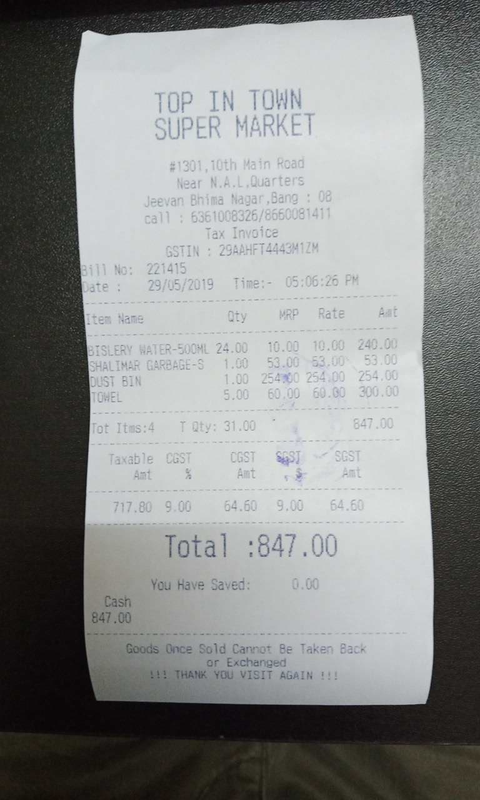

In [80]:
filePath = "Data/f980a8bc.jpeg"

img = Image.open(filePath)
img.thumbnail((800, 800), Image.ANTIALIAS)
img

Recipt Contour Detection

In [81]:
image = cv2.imread(filePath)
resizeRatio = 500 / image.shape[0]
originalimage = image.copy()
image = resizeImage(image, resizeRatio)

Convert to Gray Scale

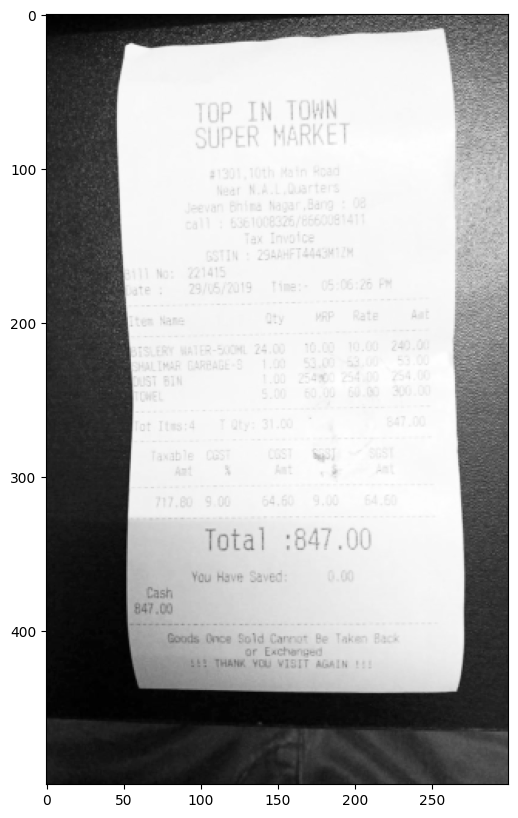

In [82]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plotGray(gray)

Noise Removal

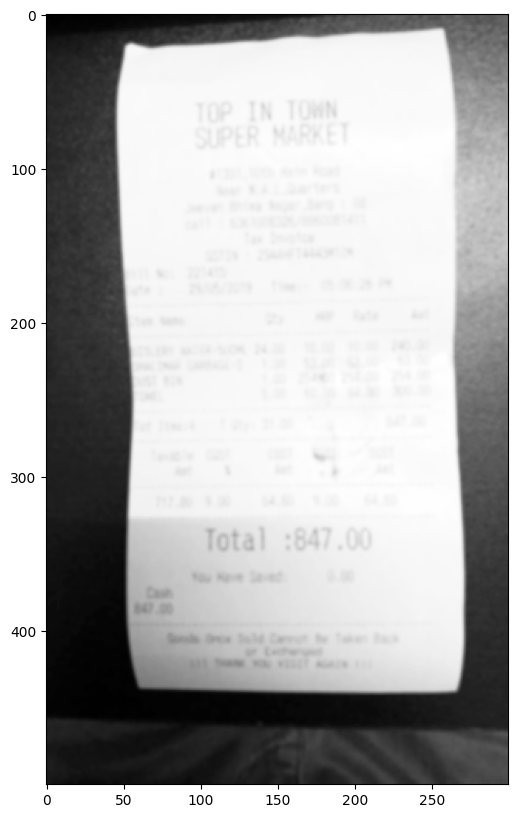

In [83]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
plotGray(blur)

Aplikasikan dilasi untuk deteksi region 

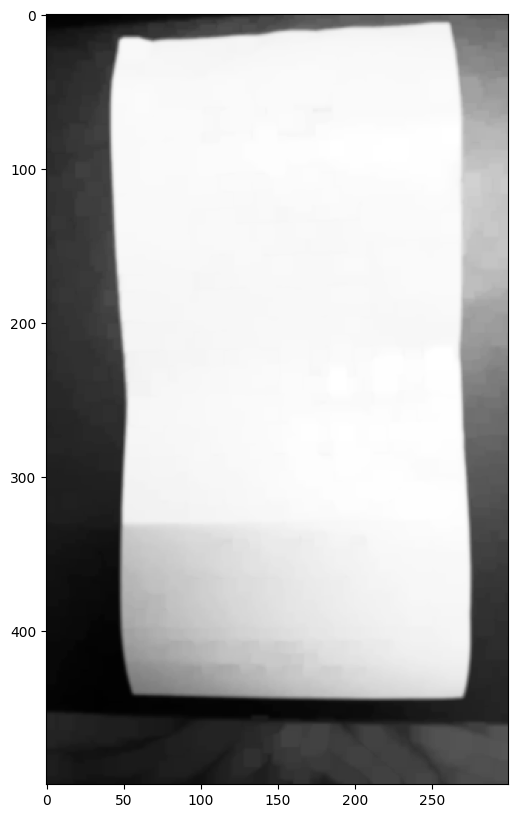

In [84]:
rectangelKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blur, rectangelKernel)
plotGray(dilated)

Aplikasikan Canny Edge Detection

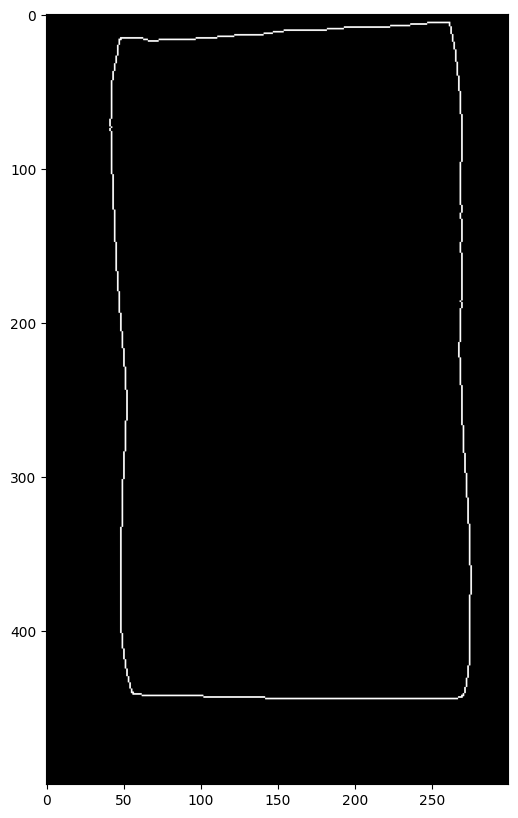

In [85]:
edge = cv2.Canny(dilated, 30, 125, apertureSize = 3)
plotGray(edge)

Deteksi semua kontur di dalam gambar canny-edged

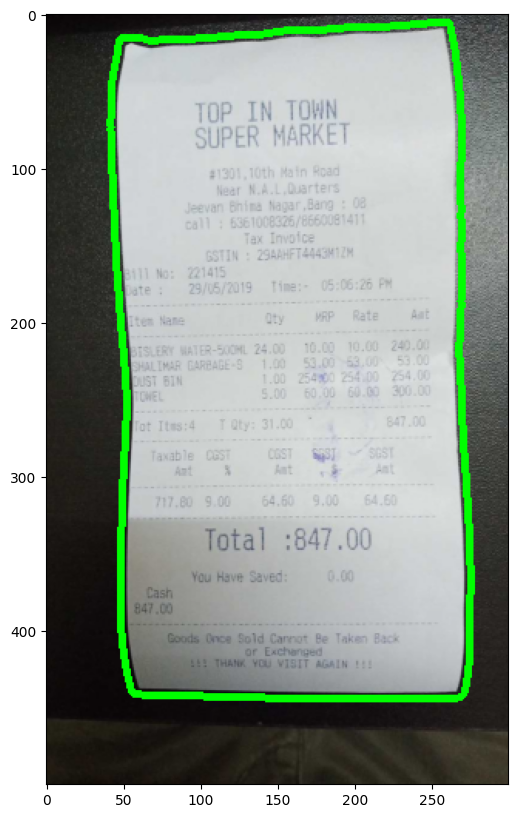

In [86]:
contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imageEithContour = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)
plotRGB(imageEithContour)

Dapatkan kontur dengan luas terbesar

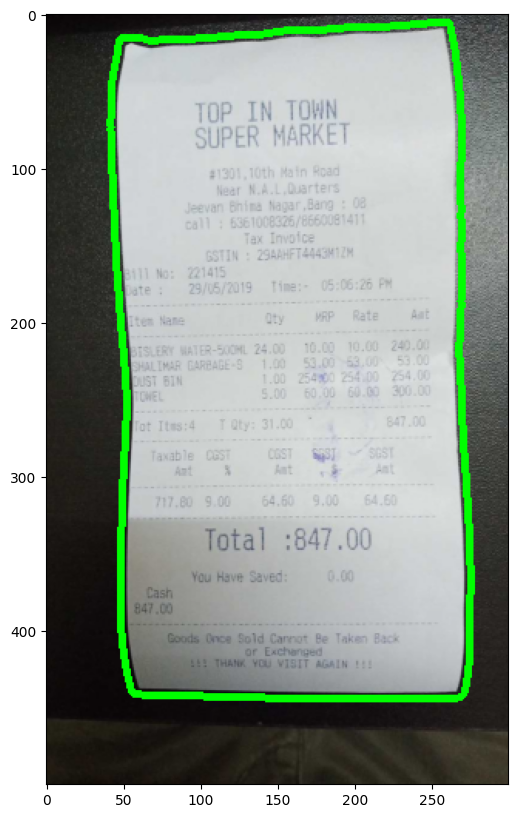

In [87]:
largestContour = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
imageWitghLargestContours = cv2.drawContours(image.copy(), largestContour, -1, (0, 255, 0), 3)
plotRGB(imageWitghLargestContours)

In [88]:
getContour(largestContour)

array([[[261,   5]],

       [[ 47,  16]],

       [[ 56, 441]],

       [[271, 440]]], dtype=int32)

In [89]:
receiptContour = getContour(largestContour)

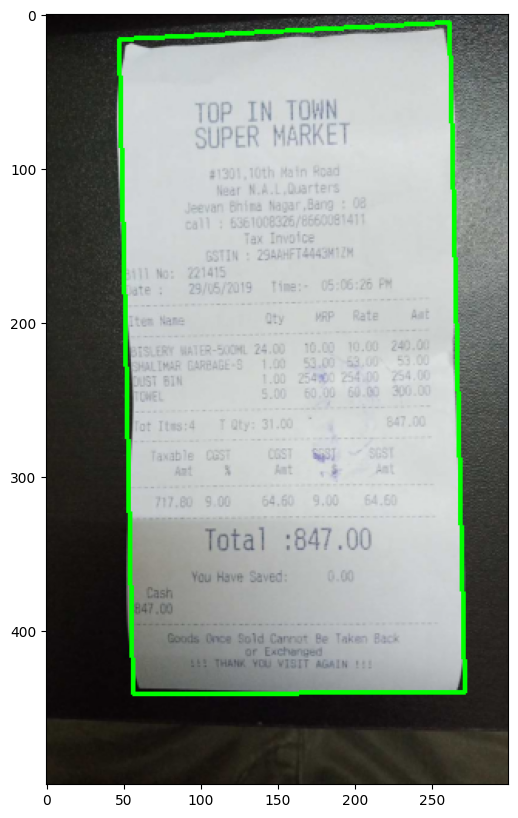

In [90]:
imageWithReceiptContour = cv2.drawContours(image.copy(), [receiptContour], -1, (0, 255, 0), 2)
plotRGB(imageWithReceiptContour)

Tampilkan hasil deteksi kontur / Crop gambar

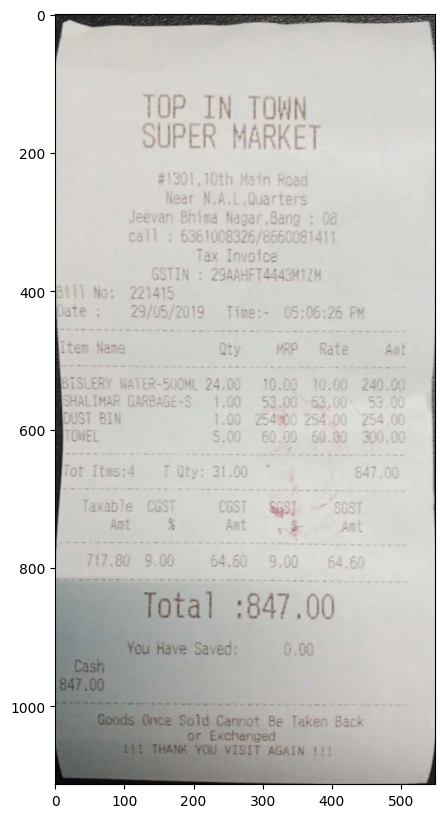

In [91]:
scannedContour = warpPerspective(originalimage.copy(), contourToRect(receiptContour))
plt.figure(figsize=(16, 10))
plt.imshow(scannedContour)

Thresholding

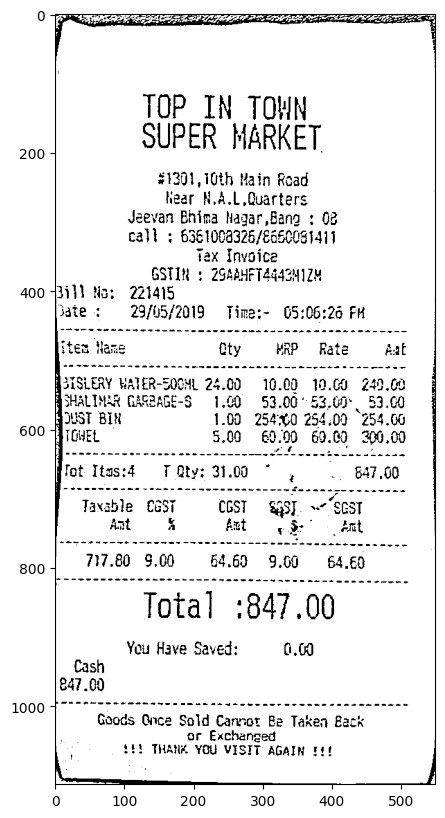

In [92]:
resultImage = blackAndWhite(scannedContour)
plotGray(resultImage)

In [93]:
# Simpan hasil gambar
output = Image.fromarray(resultImage)
output.save("Processed/hasil.jpeg")

OCR MODEL

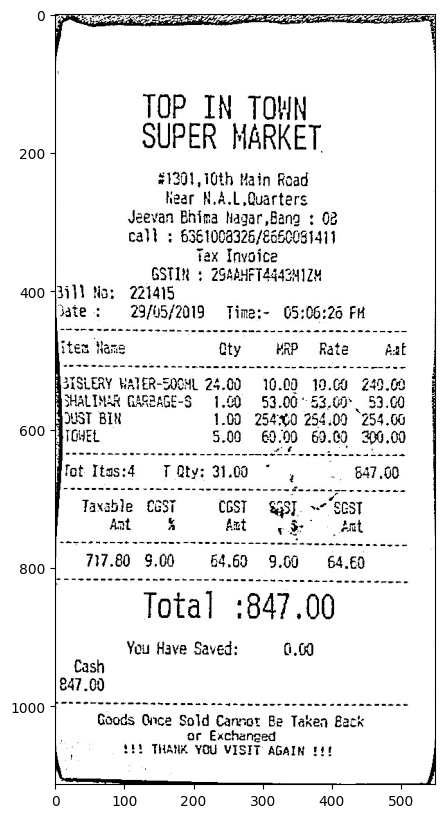

In [94]:
fileName = "Processed/hasil.jpeg"
image = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
plotGray(image)

Text Detection

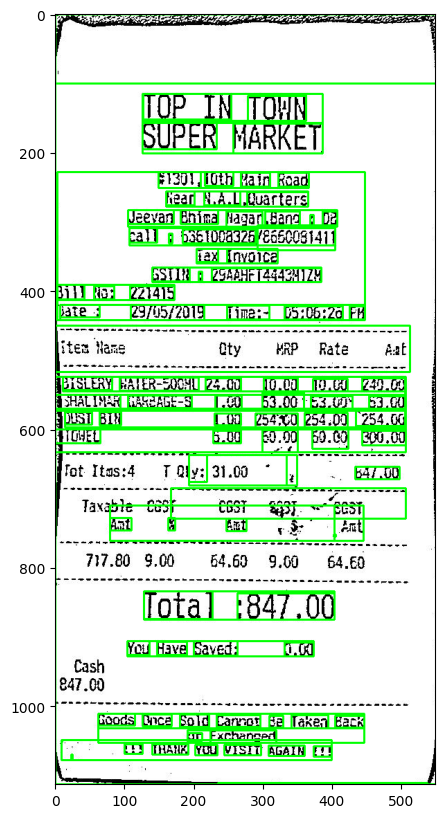

In [96]:
# Bounding box

part = pytesseract.image_to_data(image, output_type = Output.DICT)

nBoxes = len(part['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(nBoxes):
    (x, y, w, h) = (part['left'][i], part['top'][i], part['width'][i], part['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plotRGB(boxes)

Text Recognition

In [97]:
customConfig = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(image, config = customConfig)
print(text)

TOP_IN TOWN
SUPER MARKET.
#1301, 10th Hain Road .
Kear N.A.L Quarters
Jeevan Bhima Nagar ,Bang : 02
call + 6361008326 /266009141)
Tax Invoice
GSTIN + ZGAAHFT444317M
Bil) No: 221415
Bate: 29/05/2019 Times- 65:06:26 FH
item Nang Qty HRP Rate da
SESLERY HATER-SOOML 24.00 10.00 10.00 249.00 |
QsHaLIMAR GARBAGE-S 1,00 53.00"53.00' | 53.00
QUST BIN 1.00 2540 254.00 254.00
qUGHEL 5.00 £9.00 69.00 306.00
drot Ttas:4T Oty: 31.00 y  , 847.00
Taxable 063T 6ST SS]. -“SCST
Ant 4 Ant, Ss Amt
717.80 §.00 64.69 9.00 64.60
Total :847.00
You Have Saved: 0.8
Cash
847.00
. Goods Qnce Sold Cannot Be Taken Back
: or Exchanged
; ff) THANK YOU VISIT AGAIN fit



Aplikasikan Regexp

In [ ]:
# Exception
exceptList = ["Subtotal", "Total", "Tax", "Total Due", "Total Amount", "Amount Due", "Amount", "Due"]

# removedList 
removedList = ['vit', 'etc']